# Task 8: Planning

In each of the previous notebooks, we looked at one specific subtask necessary for controlling the robot (and completing the project). In this notbook, we will finally be putting everything together. The goal of this notebook is to implement path following, tasks and scheduling, which depend on the things we learned in the previous notebooks, like map creation or driving to a point, and in turn form the basis for completing the project task.

## Imports

In [1]:
import numpy as np

import sys
import os
sys.path.insert(1, os.path.join(os.getcwd(), '..'))

#from utils.utils import difference_angle

from matplotlib import pyplot as plt
import matplotlib
from utils.EKFSLAM import EKFSLAM
from utils.utils import PIDController

from utils.robot_dummy import DummyVehicle
from utils.utils import load_config
def difference_angle(angle1, angle2):
    difference = (angle1 - angle2) % (2*np.pi)
    difference = np.where(difference > np.pi, difference - 2*np.pi, difference)
    difference = difference.item()
    return difference

## Creating a World Map

**Task:** Implement a map that the robot can use for path finding and initialise it.

**Note:** You can just use your map implementation from notebook 7 for this.

In [2]:
### Your code here ###
map_size = 4
marker_size = 0.09
step_size = 0.01
Map = np.zeros((int(map_size / step_size), int(map_size / step_size)))
###

**Task:** Implement functions that transform given world coordinates to map coordinates and vice versa. Also implement a map representation of the world with a function for adding new objects (markers) to it.

**Note:** You can just use your functions from notebook 7 for this.

In [93]:
### Your code here ###
def world_to_map(pos,step_size,map_size):
    
    new_pos = pos + map_size / 2
    
    return np.round(new_pos / step_size).astype(int)

def map_to_world(pos, step_size, map_size):
    new_pos = pos -int(map_size / (2 * step_size))

    return new_pos * step_size
###

**Task:** Add the given markers to the map and and visualize the map afterwards.

In [4]:
markers_slam = (np.array([[ 0.35988178,  0.03438656],
            [ 0.46746729, -0.10735373],
            [ 0.59155068,  0.01508132]]),
     np.array([[ 0.00243039,  0.00058545,  0.10204815],
            [ 0.00414831,  0.001392  , -0.20395623],
            [ 0.00306644,  0.00126878,  0.04704469]]),
     np.array([821, 902, 557]))

coords, poses, ids = markers_slam

In [5]:
### Your code here

### ### Your code here ###
def add_marker(Map, pos, marker_size):
    
    x, y = world_to_map(pos,step_size,map_size)
    ms = int(marker_size / (2*step_size))
    
    Map[y-ms:y+ms, x-ms:x+ms] = 1

###

(0.0, 400.0)

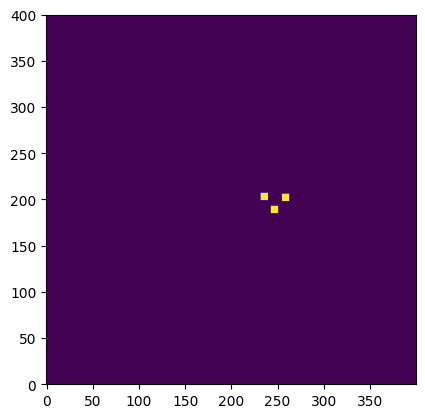

In [155]:
### Your code here ###
for coord in coords:
    add_marker(Map, coord, marker_size)
plt.imshow(Map)
plt.ylim(0, 400)
###

## Following a Path

In previous notebooks, we have already implemented functions for driving to a point and for finding optimal paths. Now we want to combine the two and have our robot follow a path found by out path finding algorithm.

**Task:** Implement a pathfinding algorithm for your map.

**Note:** You can just use your implementation from notebook 7.

In [172]:
### Your code here ###
#Map = np.zeros((10, 10))
#Map[3:5, 3:6] = 1   

def find_path(Map, start, goal):
    G = np.full(Map.shape, np.inf, dtype=float)
    
    # pre compute all values for H
    i, j = Map.shape
    ii, jj = np.meshgrid(np.arange(i), np.arange(j))
    
    # saves x and y distances seperately to compute grid distance
    distances = np.abs([ii - goal[0], jj - goal[1]])
    d_max = np.max(distances, axis=0).T
    d_min = np.min(distances, axis=0).T
    H = (d_max - d_min) * 10 + d_min * 14

    # saves positions of obstacles and already known nodes
    # init as copy of map to exlude obstacle nodes from pathfinding
    mask = np.array(Map, dtype=bool)
    F = np.ma.MaskedArray(G + H, mask)

    # for every discovered node save where optimal path came from
    pred = np.zeros((i, j, 2), dtype=int)
    
    x, y = start
    G[x, y] = 0

    neighbours = lambda x, y: np.array([
        [x, y + 1],
        [x, y - 1], 
        [x - 1, y], 
        [x + 1, y], 
        [x - 1, y - 1],
        [x - 1, y + 1],
        [x + 1, y - 1],
        [x + 1, y + 1]
    ])
    
    while np.any((x, y) != goal):
        Gc = G[x, y]
        mask[x, y] = 1
        
        for num, (nx, ny) in enumerate(neighbours(x, y)):  
            if not mask[nx, ny]:
                # diagonal neighbour distance is 14 instead of 10
                d = 14 if num > 3 else 10

                if Gc + d < G[nx, ny]:
                    G[nx, ny] = Gc + d
                    pred[nx, ny] = (x, y)
    
                F[nx, ny] = G[nx, ny] + H[nx, ny]
        
        # Search for min F chordinates
        F_min = np.min(F)
        min_idxs = np.where(F.flatten() == F_min)[0]
        
        # Select min index based on smallest H value
        H_values = H.flatten()[min_idxs]
        min_idx = min_idxs[np.argmin(H_values)]
        
        x, y = np.unravel_index(min_idx, F.shape)

    # backtracking
    path = []
    while np.any((x, y) != start):
        path.append((x, y))
        x, y = pred[x, y]

    return path
###

**Task:** Find the shortest path between the two given points

In [173]:
start_point = np.array((0,0), dtype=float)
end_point = np.array((0,0.99))
### Your code here ###
start_point_map = world_to_map(start_point, step_size, map_size)
end_point_map = world_to_map(end_point, step_size, map_size)
path = find_path(Map, start_point_map, end_point_map)
###

**Task:** Visualise your path on the map.

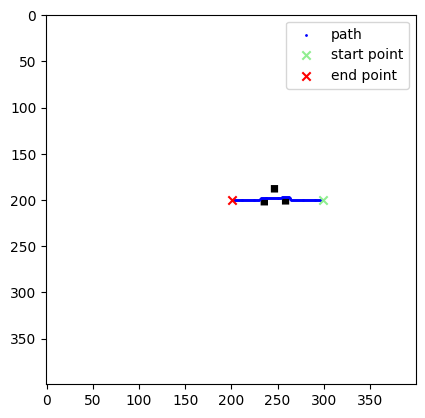

In [174]:
path_y, path_x = list(zip(*path))
plt.imshow(Map, cmap="binary")
#plt.xticks(np.arange(0, map_size+25, 25), np.arange(-int(np.round(map_size/2)), int(np.round(map_size/2))+25, 25))
#plt.yticks(np.arange(0, map_size+25, 25), np.arange(-int(np.round(map_size/2)), int(np.round(map_size/2))+25, 25))
plt.scatter(path_x, path_y, marker="o", color="blue", label="path", s=1)
plt.scatter([path_x[0]], [path_y[0]], marker="x", color="lightgreen", label="start point")
plt.scatter([path_x[-1]], [path_y[-1]], marker="x", color="red", label="end point")
plt.legend()
plt.show()

Having the robot try to reach every single point along the path in the discretised map would be very inefficient and very likely unnecessary. Instead, it makes more sense to select a subsample from the total number of points along the path that is sufficient for the robot to follow the path closely enough. E.g. when driving in a straight line, it should be sufficient to only include the start and end point of the line, because all other points along the line only provide redunant information.

**Task:** Write a function that selects the relevant points that the robot need to follow the path from the path returned by your pathfinding algorithm.

**Note:** There are also much more elegant solutions to this than just selecting a fixed subset of way points. Feel free to come up with your own solutions!

In [71]:
def robot_path(path,step_size,map_size):
    directions = (path - np.roll(path, 1, axis=0))
    dir_changes = np.any(directions != np.roll(directions, -1, axis=0), axis=1)
    return map_to_world(path[dir_changes][::-1], step_size, map_size)
    
rpath = robot_path(path,step_size,map_size)  
print(rpath)


[[ 0.    0.01]
 [ 0.    0.3 ]
 [-0.02  0.32]
 [-0.02  0.54]
 [-0.03  0.55]
 [-0.03  0.62]
 [ 0.    0.65]
 [ 0.    0.99]]


**Task:** Select the relevant points from the path found in the pathfinding task above and visualise them.

[[ 0.    0.01]
 [ 0.    0.3 ]
 [-0.02  0.32]
 [-0.02  0.54]
 [-0.03  0.55]
 [-0.03  0.62]
 [ 0.    0.65]
 [ 0.    0.99]]


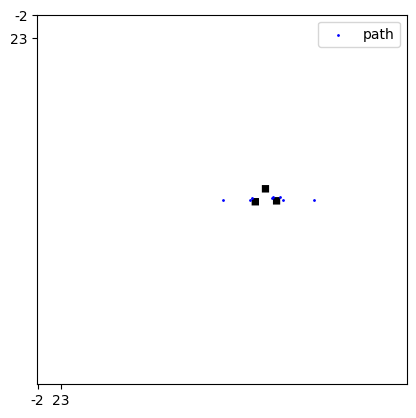

In [73]:
path_map = world_to_map(rpath, step_size, map_size)
plt.imshow(Map, cmap="binary")
plt.xticks(np.arange(0, map_size+25, 25), np.arange(-int(np.round(map_size/2)), int(np.round(map_size/2))+25, 25))
plt.yticks(np.arange(0, map_size+25, 25), np.arange(-int(np.round(map_size/2)), int(np.round(map_size/2))+25, 25))
plt.scatter(path_map[:,1],path_map[:,0], marker="o", color="blue", label="path", s=1)
#plt.scatter([path_x[0]], [path_y[0]], marker="x", color="lightgreen", label="start point")
#plt.scatter([path_x[-1]], [path_y[-1]], marker="x", color="red", label="end point")
plt.legend()
plt.show()

Now that we can extract the relevant way points from our path, we want our robot to follow the path, i.e. sequentially pass through all selected way points. For this, we will again use our the simulated robot we used in *notebook 6*.

First we initialise our simulated robot.

In [141]:
config = load_config("../config.yaml")
start_x = 0.0
start_y = 0.0
start_theta = 0.0
robot = DummyVehicle(start_x, start_y, start_theta, config.robot.wheel_radius, config.robot.width, 0.01, 0.01, np.pi/4)

config:
{
    'robot': {'wheel_radius': 0.027216, 'width': 0.15, 'delta_t': 0.15},
    'camera': {'y_offset': 0.0, 'z_offset': 0.273, 'x_angle': -126.5, 'exposure_time': 80, 'gain': 50},
    'ekf_slam': {'robot_width': 0.15, 'motor_std': 4, 'dist_std': 0.1, 'angle_std': 4},
    'pid_controller': {'P': 100, 'I': 0, 'D': 0}
}

**Task:** Implement and set up the PID controller for your path following function.

**Note:** You can just reuse your implementation from notebook 6.

In [75]:
positions = []

def follow_path(path):
    
    eps_dist = .02
    eps_angle = .1
    mx_speed = 100
    PID = PIDController(50,0.01,0.02)
    for point in path: 
        while np.hypot(point[0]- robot.x, point[1] - robot.y) >=eps_dist:
            
            delta_x = point[0] - robot.x
            delta_y = point[1] - robot.y
            angle_to_point = np.arctan2(delta_y, delta_x)
            angle = difference_angle(angle_to_point,robot.theta)
            #######################
            positions.append([robot.x,robot.y])
            #######################
            turn = PID.get_u(-angle)
            speed = mx_speed

            if abs(angle) > eps_angle:
                speed = 0
            
            robot.move(speed,turn)
    
follow_path(rpath)
    
    


   

50 0.01 0.02

[[ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 3.22993823e-04  3.66005618e-03]
 [ 5.99046893e-04  7.32395895e-03]
 [ 8.34349518e-04  1.09907097e-02]
 [ 1.03427924e-03  1.46595632e-02]
 [ 1.20350437e-03  1.83299642e-02]
 [ 1.34607618e-03  2.20014993e-02]
 [ 1.46550977e-03  2.56738617e-02]
 [ 1.56485470e-03  2.93468237e-02]
 [ 1.64675652e-03  3.30202170e-02]
 [ 1.71351032e-03  3

(150.0, 250.0)

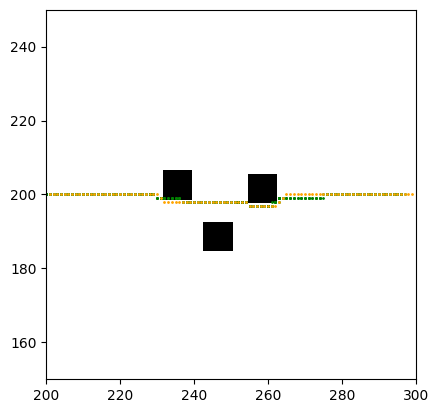

In [76]:
positions2 = np.array(positions)
positions2 = world_to_map(positions2,step_size,map_size)
plt.imshow(Map, cmap="binary")
plt.scatter(positions2[:,1],positions2[:,0],color="g",s=1)
plt.scatter(path[:,1],path[:,0],color="orange",s=1)
plt.xlim(200, 300)
plt.ylim(150, 250)


**Task:** Implement a path following function for the simulated robot. 

**Note:** Depending on how you are implementing it, it might make sense to reuse your *drive_to_point* function from notebook 6.

In [77]:
### Your code here ###

###

**Task:** Simulate the robot following the path from the tasks above.

In [78]:
### Your code here ###

###

**Task:** Visualise the path the simulated robot took and compare it to the optimal path returned by your path planning algorithm.

In [79]:
### Your code here ###

###

## Sequential Tasks and Scheduling

Now we want to put everything together, and use it to make the robot plan and execute a sequence of tasks. Look at the sequence diagram below. The robot has four tasks it has to complete. *Task 2* and *task 3* depend on *task 1*, meaning that before it can start with *task 2* or *task 3*, *task 1* has to be completed. Similarly, *task 4* depends on *task 2* and *task 3*, but they don't have to be completed in any specific order.

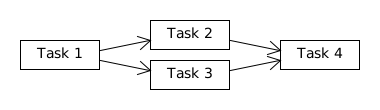

To simplify everything a bit, we assume that driving close enough to the location of the task means the robot has completed it.

**Task:** Implement a task representation in the *Task* class below. It should contain a location, id, and a list of dependencies, meaning tasks that have to be completed before the robot can start this task.

In [120]:
### Your code here ###
class Task:
    def __init__(self, id, loc, dependencies):
        self.id = id
        self.loc = loc
        self.dependencies = dependencies

        self.completed = False
    
    def can_start(self):       
        for task in self.dependencies:
            if not task.completed:
                return False
            
        return True
###

**Task:** Create task objects for the following tasks:
- Task 1:
  - x: 0.2
  - y: 0.25
  - dependencies: none
- Task 2:
  - x: 0.5
  - y: -0.45
  - dependencies: Task 1
- Task 3:
  - x: 0.75
  - y: 0.5
  - dependencies: Task 1
- Task 4:
  - x: -0.6
  - y: -0.6
  - dependencies: Task 2 and Task 3

In [142]:
### Your code here ###
task1 = Task(1, (0.2, 0.25), [])
task2 = Task(2, (0.5, -0.45), [task1])
task3 = Task(3, (0.75, 0.5), [task1])
task4 = Task(4, (-0.6, -0.6), [task1, task2])
###

**Task:** Set up all necessary parameters for your path following algorithm (PID controller parameters etc.)

In [143]:
### Your code here ###
positions = []

def do_tasks(tasks):
    count = 0
    
    while count < len(tasks):
        doable = []
        for task in tasks:
            if task.can_start() and not task.completed:
                doable.append(task)
                print(task.id)
        min_idx = 0
        min_dist = np.inf

        for i, task in enumerate(doable):
            dx = task.loc[0] - robot.x
            dy = task.loc[1] - robot.y
            dist = np.hypot(dx, dy)
            
            if dist < min_dist:
                min_dist = dist
                min_idx = i
        
            
        next_coords = np.array(doable[min_idx].loc,dtype=float)
        next_coords_map = world_to_map(next_coords, step_size, map_size)
        rpos = np.array((robot.x,robot.y), dtype=float)
        
        rpos_map = world_to_map(rpos, step_size, map_size)


        path = find_path(Map,rpos_map,next_coords_map)
        rpath = robot_path(path,step_size,map_size)
        follow_path(rpath)
        print(f"pos: {rpos}")
        doable[min_idx].completed = True
        count += 1
###

Next, we initialise our simulated robot at starting position (0,0).

In [144]:
config = load_config("../config.yaml")
start_x = 0.0
start_y = 0.0
start_theta = 0
robot = DummyVehicle(start_x, start_y, start_theta, config.robot.wheel_radius, config.robot.width, 0.01, 0.01, np.pi/4)
# init slam
slam = EKFSLAM(
        config.robot.wheel_radius,
        config.ekf_slam.robot_width,
        MOTOR_STD=config.ekf_slam.motor_std,
        DIST_STD=config.ekf_slam.dist_std,
        ANGLE_STD=config.ekf_slam.angle_std,
        init_state = np.array([robot.x, robot.y, robot.theta])
    )

config:
{
    'robot': {'wheel_radius': 0.027216, 'width': 0.15, 'delta_t': 0.15},
    'camera': {'y_offset': 0.0, 'z_offset': 0.273, 'x_angle': -126.5, 'exposure_time': 80, 'gain': 50},
    'ekf_slam': {'robot_width': 0.15, 'motor_std': 4, 'dist_std': 0.1, 'angle_std': 4},
    'pid_controller': {'P': 100, 'I': 0, 'D': 0}
}

**Task:** Implement an algorithm that lets the robot perform tasks 1-4 in a viable order. When it has completed one task, it should always start the closest viable task next, thereby minimising the overall distance it has to move. Visualise the path your robot takes on the map.

**Note:** Remember that the robot should still keep sufficient distance to the markers.

In [145]:
### Your code here ###

tasks = [task1,task2,task3,task4]
do_tasks(tasks)
### 

1


50 0.01 0.02

pos: [0. 0.]
2
3


50 0.01 0.02

pos: [0.19794747 0.23286902]
2


50 0.01 0.02

pos: [0.73183319 0.50043   ]
4


50 0.01 0.02

pos: [ 0.49881493 -0.43045812]


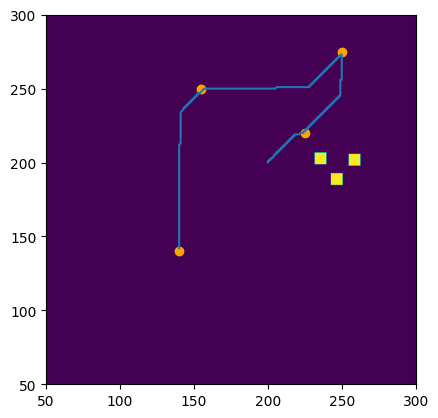

In [154]:
pos_robot = world_to_map(np.array(positions, dtype=float), step_size, map_size)
plt.plot(pos_robot[:,1],pos_robot[:,0])
plt.imshow(Map)
plt.xlim(50, 300)
plt.ylim(50, 300)
for task in tasks:
    task_loc = world_to_map(np.array(task.loc, dtype=float), step_size, map_size)
    plt.scatter(task_loc[1], task_loc[0], color='orange')